In [1]:
from iexfinance.stocks import Stock, get_historical_data, get_historical_intraday
from iexfinance import get_market_tops, get_stats_intraday
from ipywidgets import widgets, interact
import tweepy

import csv
import sys
import re
import string
import json
import os
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import numpy as np

import ast
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
lemma = nltk.WordNetLemmatizer()  
import textblob
from textblob import TextBlob
import glob

In [4]:
symbol = widgets.Text(
            description='Enter symbol:'
        )

display(symbol)

def callback(wdgt):
    # replace by something useful
    display(symbol.value)

symbol.on_submit(callback)

Text(value='', description='Enter symbol:')

'AAPL'

In [7]:
stock = Stock(symbol.value,token="sk_0401bc5c47294b4f998f03ed99c50128")
stock.get_open()

262.5

In [ ]:
# symbol.value

In [8]:
stock.get_company()['companyName']

'Apple, Inc.'

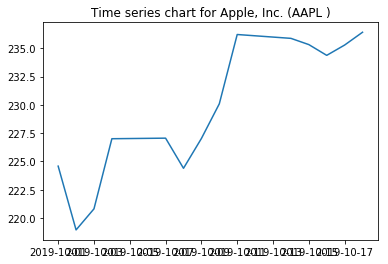

In [9]:
start = datetime(2019, 10, 1)
end = datetime(2019, 10, 20)

df = get_historical_data(symbol.value, start, end, output_format='pandas',token="sk_0401bc5c47294b4f998f03ed99c50128")

plt.title('Time series chart for ' + stock.get_company()['companyName'] + ' (' + symbol.value + ' )')
plt.plot(df["close"])
plt.show()

In [10]:
STOCKNAME = "AAPL"
DF = pd.DataFrame()

In [11]:
#Method to authenticate twitter api
def initializeTwitterAPI(keys):
    auth = tweepy.OAuthHandler(keys['consumer_key'], keys['consumer_secret'])
    auth.set_access_token(keys['access_token'], keys['access_token_secret'])
    api = tweepy.API(auth, wait_on_rate_limit=True)
    return api

In [12]:
#Method for data cleaning
class TweetCleaner:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.punc_table = str.maketrans("", "", string.punctuation) # to remove punctuation from each word in tokenize

    def compound_word_split(self, compound_word):
        matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', compound_word)
        return [m.group(0) for m in matches]

    def remove_non_ascii_chars(self, text):
        return ''.join([w if ord(w) < 128 else ' ' for w in text])

    def remove_hyperlinks(self,text):
        return ' '.join([w for w in text.split(' ')  if not 'http' in w])

    def get_cleaned_text(self, text):
        cleaned_text = text.replace('\"','').replace('\'','').replace('-',' ')
        cleaned_text =  self.remove_non_ascii_chars(cleaned_text)
        if re.match(r'RT @[_A-Za-z0-9]+:',cleaned_text):
            cleaned_text = cleaned_text[cleaned_text.index(':')+2:]
        cleaned_text = self.remove_hyperlinks(cleaned_text)
        cleaned_text = cleaned_text.replace('#','HASHTAGSYMBOL').replace('@','ATSYMBOL') # to avoid being removed while removing punctuations
        tokens = [w.translate(self.punc_table) for w in word_tokenize(cleaned_text)] # remove punctuations and tokenize
        tokens = [lemma.lemmatize(w) for w in tokens if not w.lower() in self.stop_words and len(w)>1] # remove stopwords and single length words
        cleaned_text = ' '.join(tokens)
        cleaned_text = cleaned_text.replace('HASHTAGSYMBOL','#').replace('ATSYMBOL','@')
        cleaned_text = cleaned_text
        return cleaned_text

    def clean_tweets(self, tweets, is_bytes = False):   
        test_tweet_list = []
        for tweet in tweets:
            if is_bytes:
                test_tweet_list.append(self.get_cleaned_text(ast.literal_eval(tweet).decode("UTF-8")))
            else:
                test_tweet_list.append(self.get_cleaned_text(tweet))
        return test_tweet_list
    
    def clean_single_tweet(self, tweet, is_bytes = False):  
        if is_bytes:
             return self.get_cleaned_text(ast.literal_eval(tweet).decode("UTF-8"))
        return self.get_cleaned_text(tweet)
    
    def cleaned_file_creator(self, op_file_name, value1, value2):
        csvFile = open(op_file_name, 'w+')
        csvWriter = csv.writer(csvFile)
        for tweet in range(len(value1)):
            csvWriter.writerow([value1[tweet], value2[tweet]])
        csvFile.close()

In [13]:
#Methodto fetch tweets from twitter api
def fetchTweets(api, filename):
    # Open/Create a file to append data
    csvFile = open(filename + '.csv', 'a')
    csvWriter = csv.writer(csvFile, lineterminator= '\n')
    obj = TweetCleaner()
    
    for tweet in tweepy.Cursor(api.search,q=STOCKNAME, lang="en", since_id="2018-12-1").items():
        follower_count = tweet.user.followers_count
        tweet_text = tweet.text.encode('utf-8')
        tweet_text = obj.get_cleaned_text(tweet_text.decode())
#         print("the text is: ", tweet_text)
        csvWriter.writerow([tweet.created_at, tweet_text.encode('utf-8'),follower_count])



In [14]:
#Methodthat uses textblob  for sentiment analysis for fetched tweets
def sentimentAnalysis(tFilename, sFilename):
    colnames=['date', 'text', 'followers']
    df = pd.read_csv(tFilename + '.csv',encoding='latin-1', names=colnames, header=None)
    df['polarity'] = 0.0000
    df['sentiment_confidence'] = 0.0000

    for index,row in df.iterrows():
        analysis = TextBlob(df['text'][index])
        sentiment, confidence = analysis.sentiment
        df.at[index,'polarity'] = sentiment
        df.at[index,'sentiment_confidence'] = confidence

    df.to_csv(sFilename + '.csv')

In [15]:
#Method to cluster tweets using polarity, confidentce 
def clustering(sFilename, cFilename):
    df = pd.read_csv(sFilename + '.csv', index_col=0, encoding='latin-1')
    dfold = df
    df = df.drop('text', 1)
    print(df.head())
    df = df.drop('date', 1)
    df_tr = df    
    clmns = ['followers', 'polarity', 'sentiment_confidence']
    df_tr_std= stats.zscore(df_tr[clmns])

    #Clustering
    kmeans = KMeans(n_clusters=5, random_state=0).fit(df_tr_std)
    labels = kmeans.labels_
    
    df_tr['clusters']=labels
    dfold['clusters']=labels

    clmns.extend(['clusters'])

    #Scatter plot of polarity and confidence
    sns.lmplot('polarity', 'sentiment_confidence',
               data=df_tr,
               fit_reg=False,
               hue="clusters",
               scatter_kws={"marker": "D", "s": 20})

    dfold.to_csv(cFilename + '.csv')
    plt.title('tweets grouped by polarity and sentiment_confidence')
    plt.xlabel('polarity')
    plt.ylabel('sentiment_confidences')
    plt.show()

In [16]:
def getstockvalue(change, followers, totalfollowers, polarity, confidence, currentprice):
    # determines effect of tweet on stock price change
    value = change*(followers/totalfollowers)*polarity*confidence/(currentprice)*10000
    print(value)
    return value

In [17]:
#Method to add stock difference to data
def AddStockVariation(cFilename, fFilename):
    df = pd.read_csv(cFilename + ".csv",index_col=0,encoding='latin-1')
    apple = Stock("AAPL", output_format='pandas',token="sk_0401bc5c47294b4f998f03ed99c50128")
    currentprice = apple.get_close()['AAPL'][0]
    diff = abs(currentprice - apple.get_open()['AAPL'][0])
    totalfollowers = df['followers'].sum()

    for index,row in df.iterrows():
        followers = df['followers'][index]
        polarity = df['polarity'][index]
        confidence = df['sentiment_confidence'][index]
        df.at[index,'difference'] = getstockvalue(diff, followers, totalfollowers, polarity, confidence, currentprice)

    df.to_csv(fFilename + '.csv')

In [18]:
#Training using Support vector regression
def predict_prices(X, Y, n):
    parameters_rbf = {
    "kernel": ["rbf"],
    "C": [1,10,10,100,1000],
    "gamma": [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    }
    parameters_poly = {
    "kernel": ["linear"],
    "C": [1,10,10,100,1000],
    "gamma": [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    }
    parameters_lin = {
    "kernel": ["poly"],
    "C": [1,10,10,100,1000],
    "gamma": [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    }

    svr_rbf = GridSearchCV(SVR(), parameters_rbf, cv=5, verbose=2)
    svr_rbf.fit(X, Y)
    
#    svr_lin = GridSearchCV(SVR(), parameters_lin, cv=5, verbose=2)
#    svr_lin.fit(X, Y)
    
#    svr_poly = GridSearchCV(SVR(), parameters_poly, cv=5, verbose=2)
#    svr_poly.fit(X, Y)
#     svr_lin = SVR(kernel = 'linear' , C=1)
#     svr_poly = SVR(kernel= 'poly' , C=n, degree=2)
#     svr_rbf = SVR(kernel='rbf' , C=le3, gamma = 0.1)
#     svr_lin.fit(X, Y)
#     svr_poly.fit(X, Y)
#     svr_rbf.fit(X, Y)

#     plt.scatter(dates, prices, color='black', label='Data')
#     plt.plot(np.array(X[0]), np.array(svr_rbf.predict(X)), color='red', label='RBF model')
#     plt.plot(X[0], svr_lin.predict(X), color='green', label='Linear model')
# #     plt.plot(X[0], svr_poly.predict(X), color='blue', label='Polynomial model')
#     ply.xlabel('Combined value')
#     plt.ylabel('Change in stock value')
#     plt.title('Support Vector Regression')
#     plt.legend()
#     plt.show()

    return svr_rbf.predict(X)#, svr_lin.predict(X)[0], svr_poly.predict(X)[0]    
#     return svr_rbf.predict(X)[0]

In [19]:
#method for prediction
def stockPricePrediction(fFilename):
    frame = pd.DataFrame()
    list_ = []
    colnames = ['date', 'text', 'followers', 'polarity', 'sentiment_confidence', 'clusters', 'difference']
    file_ = pd.read_csv(fFilename + '.csv',encoding='latin-1')
    file_ = file_.drop('text', 1)
    file_ = file_.drop('date', 1)
    list_.append(file_)
    frame = pd.concat(list_)
    frame.dropna(axis=1,how='any',inplace=True)
    #print(frame)
    dfinputs = frame.drop('difference',1)
    #print(type(dfinputs))

    X= np.array(dfinputs)
    Y= np.array(frame['difference'].values)
    
    predicted_price = predict_prices(X,Y,29)
    print("the prediction is: ",predicted_price)

In [20]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Arjun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

{'consumer_key': 'ZM6DJgtEJqsiyDIUOkYjAvW92', 'consumer_secret': 'owgHLD90dkhLlTygHHtAeA2F7NFF4r8VuytERlzKvnz6Yf1NGB', 'access_token': '3141529058-JxRCEZUS2LZAxguyPTh6meLvey8iN66MGvg6FKS', 'access_token_secret': 'vaS2tkeFimTiiOTB1ocSt9ukMGEStsgTxNd3OhDYDHSZq'}
{'consumer_key': 'ZM6DJgtEJqsiyDIUOkYjAvW92', 'consumer_secret': 'owgHLD90dkhLlTygHHtAeA2F7NFF4r8VuytERlzKvnz6Yf1NGB', 'access_token': '3141529058-JxRCEZUS2LZAxguyPTh6meLvey8iN66MGvg6FKS', 'access_token_secret': 'vaS2tkeFimTiiOTB1ocSt9ukMGEStsgTxNd3OhDYDHSZq'}
returned apis
tweets fetched!
sentiment analysis done
                  date  followers  polarity  sentiment_confidence
0  2019-11-23 17:22:59        858  0.000000              0.000000
1  2019-11-23 17:22:00        982  0.000000              0.000000
2  2019-11-23 17:20:29        486  0.000000              0.900000
3  2019-11-23 17:19:58        858  0.500000              0.888889
4  2019-11-23 17:15:47        858  0.266667              0.455556


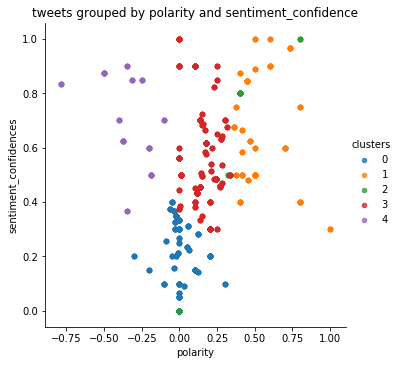

clustering done, final data
0.0
0.0
0.0
0.0007249273147667639
0.00019814679936958212
0.0006229305485212585
0.00029348150049045377
0.002641333504414083
0.0
0.0
0.0
0.0
0.08154002714183688
0.0010271852517165878
2.737487762056312e-06
0.0001252247730566359
7.5128830803101e-05
0.0
0.001054067510370328
1.836398040379442e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0017880927875781566
0.0
0.0
0.000303183368275262
-4.516168923266925e-05
0.0011917463702203685
0.0
0.0
0.0
0.00012820190621200354
0.0003420720653771323
0.00022002557887527602
8.765030260361784e-05
-3.621230556074316e-05
5.594740613702586e-05
0.0
-1.5621416019073314e-06
0.0016776617708435379
0.0
0.003344392600970532
0.0004837368999533674
0.0009092103088778014
0.0
0.0
-1.1330157681844178e-05
0.0
0.0
0.0
0.0
7.178301242725439e-05
0.002423703227330607
0.0
0.0
-4.6841457261852434e-05
2.2337139725112258e-05
-0.0013291263498050629
4.9207187426592447e-05
0.0
-4.919873839028983e-05
7.459654151603449e-05
0.08154002714183688
0.0001348382401806249
8.765030260

-2.861054917982463e-05
2.737487762056312e-06
0.00020386679694647136
0.0
0.0
8.727854500630151e-05
0.0
0.0
4.594163489562092e-06
0.0
0.0
0.0
0.0
0.00036042843065054196
0.0
0.0
3.060663400632403e-06
0.000246373898585068
0.0019022498293222413
0.0014312781510661331
0.0
0.0
0.0
0.0
0.0
0.0
0.00021026939024601567
0.0
0.0003166360844778467
6.023483294976021e-06
0.0
0.0
7.337037512261344e-05
0.0
-0.0005869630009809075
5.706584731758822e-05
0.00019565433366030248
6.524345832900876e-05
-8.623086450477382e-05
0.0
0.0
1.8107340926101648e-05
-2.128341749206966e-06
0.0
1.6966721025244847e-06
0.000921012549278501
8.765030260361784e-05
0.0
0.0006860448497020012
0.0
0.0
0.0
0.0
1.3307232176662624e-07
0.0
0.0
0.0
8.023284082705069e-06
0.0
0.0
2.804416698387577e-05
2.737487762056312e-06
8.765030260361784e-05
0.06205604354189363
0.0004854086870036568
6.178357796307647e-07
1.249401243253324e-06
0.0
-3.621230556074316e-05
0.0
7.727066150582096e-05
0.0
0.0
0.0
1.3402283835067359e-05
0.0
5.357745145413452e-05

1.2356715592615291e-05
-0.0021399692744095583
0.0033041325205366225
0.0
8.454199602605662e-05
0.0
0.0
0.0
-0.0002495106033124242
3.239347316814079e-05
7.973778010619268e-05
7.820052489001738e-06
0.001858716169772874
0.001858716169772874
0.0006071738219058867
-5.978326861842575e-05
4.3937144140147005e-05
3.189511204247709e-05
8.611680251468813e-05
0.0
0.0
-6.099940178123743e-05
0.00017223360502937628
0.00010046960293380284
0.0
0.0
-9.042264264042252e-05
0.000797521434679072
6.602075050741077e-07
5.473835874126648e-05
6.977055759291863e-05
0.0
-6.5207784620175364e-06
0.007314947506848081
-0.00018838050550088023
0.0
0.0
-2.931393145201967e-05
8.023284082705069e-06
0.0
0.0
-6.947220099848154e-06
0.0
3.1869075216319964e-05
7.176400209557344e-05
-4.2799385488191174e-05
0.0
0.0
-2.6614464353325254e-07
3.0342717136034643e-05
0.0
0.0
0.0005398934197388836
8.611680251468813e-05
0.0
0.0002111485143935412
0.0002730276377555813
0.0
8.315039867530708e-06
0.0
2.2178720294437677e-07
1.2187734866562423

0.0
0.0
0.0
0.0034674295798686945
0.0
0.0
-0.001146412111290835
0.006097906072633881
3.893652569548049e-05
0.0
0.0
0.0
0.0
0.027017111627364
0.0
2.737487762056312e-06
0.0
-0.008932479598584786
3.876693671300474e-05
8.596894437939177e-06
7.32953899254274e-06
0.0
2.957162705925025e-07
4.7092816091856066e-06
0.0
1.1003813654654596e-05
0.0066935377848612995
0.0044794282168960494
0.0
-4.524458940065292e-06
2.566394776927789e-06
0.0008434060491409455
0.0008152263902512602
1.2356715592615291e-05
-0.0021399692744095583
0.0033044603114612795
0.0
8.454199602605662e-05
0.0
0.0
0.0
-0.0002495106033124242
3.239347316814079e-05
7.973778010619268e-05
7.820052489001738e-06
0.001858716169772874
0.001858716169772874
0.0006071738219058867
-5.978326861842575e-05
4.3937144140147005e-05
3.189511204247709e-05
8.611680251468813e-05
0.0
0.0
-6.099940178123743e-05
0.00017223360502937628
0.00010046960293380284
0.0
0.0
-9.042264264042252e-05
0.000797521434679072
6.602075050741077e-07
5.473835874126648e-05
6.97705

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] C=10, gamma=1e-07, kernel=rbf ...................................
[CV] .................... C=10, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=10, gamma=1e-06, kernel=rbf ...................................
[CV] .................... C=10, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=10, gamma=1e-06, kernel=rbf ...................................
[CV] .................... C=10, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=10, gamma=1e-06, kernel=rbf ...................................
[CV] .................... C=10, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=10, gamma=1e-06, kernel=rbf ...................................
[CV] .................... C=10, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=10, gamma=1e-06, kernel=rbf ...................................
[CV] .................... C=10, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=10, gamma=1e-05, kernel=rbf ...................................
[CV] .................... C=10, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] 

[CV] ................... C=100, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=100, gamma=1e-07, kernel=rbf ..................................
[CV] ................... C=100, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=100, gamma=1e-07, kernel=rbf ..................................
[CV] ................... C=100, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=100, gamma=1e-07, kernel=rbf ..................................
[CV] ................... C=100, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=100, gamma=1e-07, kernel=rbf ..................................
[CV] ................... C=100, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=100, gamma=1e-06, kernel=rbf ..................................
[CV] ................... C=100, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=100, gamma=1e-06, kernel=rbf ..................................
[CV] ................... C=100, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=100, gamma=1e-06, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished


In [23]:
def main():
    #Initializing keys
    keys = {}
    keys['consumer_key'] = 'ZM6DJgtEJqsiyDIUOkYjAvW92'
    keys['consumer_secret'] = 'owgHLD90dkhLlTygHHtAeA2F7NFF4r8VuytERlzKvnz6Yf1NGB'
    keys['access_token'] = '3141529058-JxRCEZUS2LZAxguyPTh6meLvey8iN66MGvg6FKS'
    keys['access_token_secret'] = 'vaS2tkeFimTiiOTB1ocSt9ukMGEStsgTxNd3OhDYDHSZq'
    #Initializing twitter api
    api = initializeTwitterAPI(keys)
    print("returned apis")
    STOCKNAME = "AAPL"
    #Fetching tweets
    fetchTweets(api, "tweets_" + STOCKNAME)
    print("tweets fetched!")
    #Setntiment analysis using text blob 
    sentimentAnalysis("tweets_" + STOCKNAME, "sentiment_" + STOCKNAME)
    print("sentiment analysis done")
    #Clustering using kmeans
    clustering("sentiment_" + STOCKNAME, "cluster_" + STOCKNAME)
    print("clustering done, final data")
    #Data preparation 
    AddStockVariation("cluster_" + STOCKNAME, "finaldata_" + STOCKNAME)
    print("differences added!")
    #Training and prediction
    stockPricePrediction("finaldata_" + STOCKNAME)    
main()